# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science



## Lab 6: Missing Data, Classification and Dimensionality Reduction 

**Harvard University**<br>
**Fall 2018**<br>
**Instructors:** Pavlos Protopapas and Kevin Rader<br>
**Lab Instructors:** Pavlos Protopapas.  <br>
**Contributors:** Will Claybaugh and David Sondak

---

## Zoom 

I will be using zoom during this lab. You can connect to the room using the link  
https://harvard-dce.zoom.us/j/7607382317
and when you are ready to share your screen let me know and can share your screen. 


In [3]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Learning Goals
In this lab, we'll explore different models used to predict which of several labels applies to a new datapoint based on labels observed in the training data. We'll similarly explore PCA as a technique for reducing the number of features in a dataset with as little loss of structure as possible.

By the end of this lab, you should:
- Be familiar with the `sklearn` implementations of
 - Logistic Regression
- Be able to make an informed choice of model based on the data at hand
- Be familiar with the SKlearn implementation of Principle Components Analysis (PCA)
- Be able to select an appropriate number of PCA components
- (Bonus) Structure your sklearn code into Pipelines to make building, fitting, and tracking your models easier
- (Bonus) Apply weights to each class in the model to achieve your desired tradeoffs between discovery and false alarm in various classes

In [4]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

from sklearn.model_selection import train_test_split

## Part 1:  The Wine Dataset
The dataset contains 11 chemical features of various wines, along with experts' rating of that wine's quality. The quality scale technically runs from 1-10, but only 3-9 are actually used in the data.

Our goal will be to distinguish good wines from bad wines based on their chemical properties.

### Read-in and checking
We do the usual read-in and verification of the data:

In [5]:
wines_df = pd.read_csv("data/wines.csv", index_col=0)

wines_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red,good
0,8.9,0.590,0.50,2.0,0.337,27.0,81.0,0.99640,3.04,1.61,9.5,6,1,0
1,7.7,0.690,0.22,1.9,0.084,18.0,94.0,0.99610,3.31,0.48,9.5,5,1,0
2,8.8,0.685,0.26,1.6,0.088,16.0,23.0,0.99694,3.32,0.47,9.4,5,1,0
3,11.4,0.460,0.50,2.7,0.122,4.0,17.0,1.00060,3.13,0.70,10.2,5,1,0
4,8.8,0.240,0.54,2.5,0.083,25.0,57.0,0.99830,3.39,0.54,9.2,5,1,0


In [6]:
wines_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red,good
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,7.558400,0.397455,0.30676,4.489250,0.067218,25.29650,91.03100,0.995351,3.251980,0.572990,10.489433,5.796000,0.50000,0.189000
std,1.559455,0.189923,0.16783,4.112419,0.046931,17.06237,59.57269,0.002850,0.164416,0.169583,1.151195,0.844451,0.50025,0.391705
min,3.800000,0.080000,0.00000,0.800000,0.009000,1.00000,6.00000,0.987400,2.740000,0.280000,8.500000,3.000000,0.00000,0.000000
25%,6.500000,0.260000,0.22000,1.800000,0.042000,12.00000,37.75000,0.993480,3.140000,0.460000,9.500000,5.000000,0.00000,0.000000
50%,7.200000,0.340000,0.30000,2.400000,0.060000,22.00000,86.00000,0.995690,3.240000,0.550000,10.300000,6.000000,0.50000,0.000000
75%,8.200000,0.520000,0.40000,6.100000,0.080000,35.00000,135.00000,0.997400,3.360000,0.650000,11.300000,6.000000,1.00000,0.000000
max,15.500000,1.580000,1.00000,26.050000,0.611000,131.00000,313.00000,1.003690,3.900000,2.000000,14.000000,8.000000,1.00000,1.000000


### Building the training/test data
As usual, we split the data before we begin our analysis.

Today, we take the 'quality' variable as our target. There's a debate to be had about the best way to handle this variable. It has 10 categories (1-10), though only 3-9 are used. While the variable is definitely ordinal- we can put the categories in an order everyone agrees on- the variable probably isn't a simple numeric feature; it's not clear whether the gap between a 5 and a 6 wine is the same as the gap between an 8 and a 9.

[Ordinal regression](https://pythonhosted.org/mord/) is one possibility for our analysis (beyond the scope of this course), but we'll view the quality variable as categorical. Further, we'll simplify it down to 'good' and 'bad' wines (quality at or above 7, and quality at or below 6, respectively). This binary column already exists in the data, under the name 'good'.

In [7]:
wines_train, wines_test = train_test_split(wines_df, test_size=0.2, random_state=8, stratify=wines_df['good'])

x_train = wines_train.drop(['quality','good'], axis=1)
y_train = wines_train['good']

x_test = wines_test.drop(['quality','good'], axis=1)
y_test = wines_test['good']

x_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red
744,7.6,0.30,0.37,1.6,0.087,27.0,177.0,0.99438,3.09,0.50,9.8,0
51,7.6,0.29,0.49,2.7,0.092,25.0,60.0,0.99710,3.31,0.61,10.1,1
213,13.2,0.46,0.52,2.2,0.071,12.0,35.0,1.00060,3.10,0.56,9.0,1
883,8.6,0.33,0.34,11.8,0.059,42.0,240.0,0.99882,3.17,0.52,10.0,0
98,7.7,0.41,0.76,1.8,0.611,8.0,45.0,0.99680,3.06,1.26,9.4,1


Now that we've split, let's explore some patterns in the data

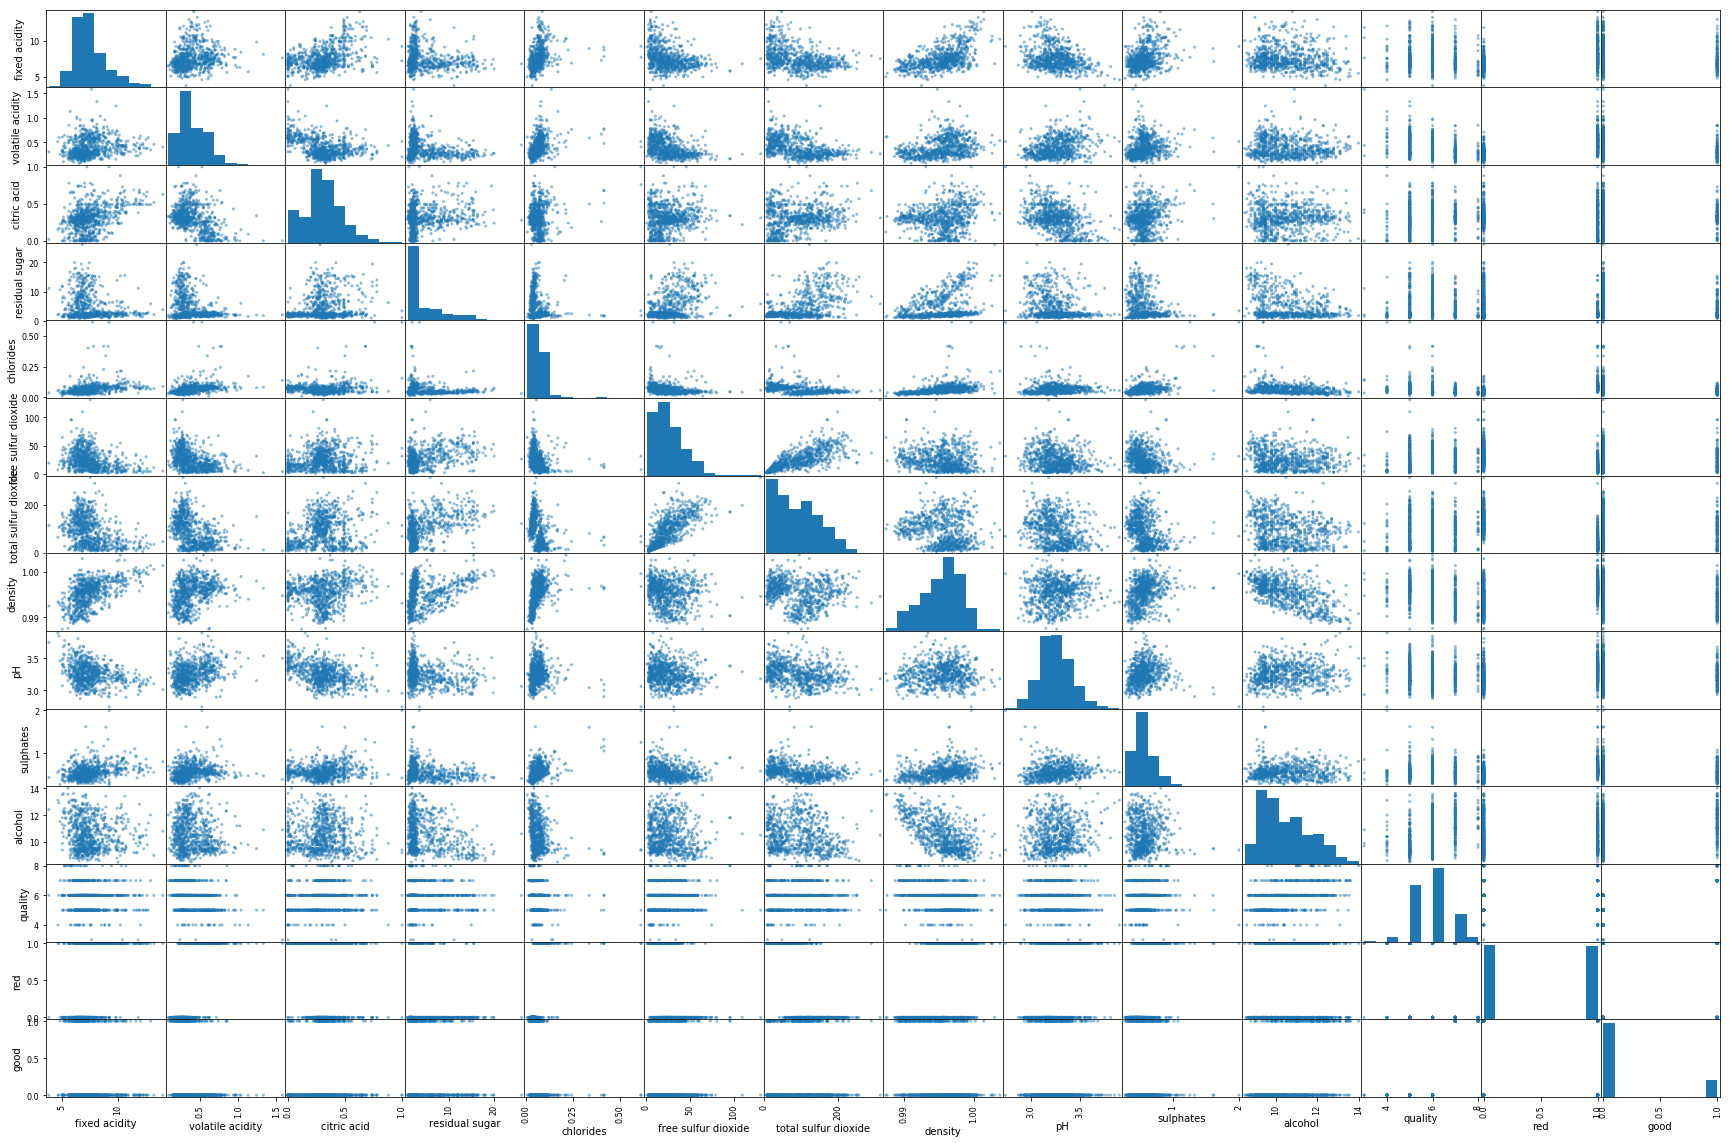

In [8]:
from pandas.plotting import scatter_matrix

scatter_matrix(wines_train, figsize=(30,20));

It looks like there aren't any particularly strong correlations among the predictors (maybe sulfur dioxide and free sulfur dioxide) so we're safe to keep them all. It also looks like the different quality categories have roughly the same distribution of most variables, with volatile/fixed acidity and alcohol seeming like the most useful predictors.

## Part 2 (Introduction): Binary Logistic Regression
Linear regression is usually a good baseline model, but since the outcome we're trying to predict only takes values 0 and 1 we'll want to use logistic regression instead of basic linear regression.

We'll begin with `statsmodels`, because `cs109` likes confidence intervals and checking that coefficients make sense.

In [9]:
import statsmodels.api as sm
sm_fitted_logit = sm.Logit(y_train, sm.add_constant(x_train)).fit()
#sm_fitted_logit.summary() ### ORIGINAL VERSION.  GAVE AttributeError: module 'scipy.stats' has no attribute 'chisqprob'
sm_fitted_logit.summary2() ### WORKS

/Users/winniewang/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Optimization terminated successfully.
         Current function value: 0.372167
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
=========================================================================
Model:                  Logit              Pseudo R-squared:   0.232     
Dependent Variable:     good               AIC:                621.4673  
Date:                   2018-10-19 19:52   BIC:                682.3672  
No. Observations:       800                Log-Likelihood:     -297.73   
Df Model:               12                 LL-Null:            -387.52   
Df Residuals:           787                LLR p-value:        5.1997e-32
Converged:              1.0000             Scale:              1.0000    
No. Iterations:         10.0000                                          
-------------------------------------------------------------------------
                       Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-------------------------------------------------------------------------
const                 296.7882 178.7587  1.6603 0.0969  -53.5724 647.1488
fixed acidity           0.4228   0.1962  2.1546 0.0312    0.0382   0.8073
volatile acidity       -3.6301   1.1006 -3.2983 0.0010   -5.7872  -1.4729
citric acid            -0.8217   1.0638 -0.7724 0.4399   -2.9066   1.2633
residual sugar          0.1628   0.0759  2.1454 0.0319    0.0141   0.3115
chlorides             -18.8903   8.1523 -2.3172 0.0205  -34.8684  -2.9121
free sulfur dioxide     0.0026   0.0089  0.2864 0.7746   -0.0150   0.0201
total sulfur dioxide   -0.0036   0.0038 -0.9597 0.3372   -0.0110   0.0038
density              -312.9457 182.0829 -1.7187 0.0857 -669.8215  43.9302
pH                      1.5112   1.1276  1.3402 0.1802   -0.6989   3.7212
sulphates               2.5571   0.8610  2.9700 0.0030    0.8696   4.2446
alcohol                 0.4945   0.2190  2.2580 0.0239    0.0653   0.9236
red                     0.6751   0.6490  1.0403 0.2982   -0.5968   1.9470
=========================================================================

"""

Let's talk about the output:  
First, "optimization terminated successfully". Recall that linear regression and its simple formula for the optimal betas is a rarity in machine learning and statistics: most models are fit to the data algorithmically, not via a formula. This message is letting us know that the algorithm seems to have worked.

Second, the pseudo $R^2$ is rather low (.23). As with regular $R^2$, we might take this as a sign that the model is struggling.

Finally, let's look at the coefficients. 
 - Several of the coefficients are statistically significant, including
    - Fixed acidity - good
    - Volatile Acidity - bad
    - Residual Sugar - good (judge have a sweet tooth?)
    - Chlorides - bad
    - Sulphates - good
    - Alcohol - good (judges like getting drunk?)
    - The rest only reach a coefficient size we would often observe by chance alone, without any actual effect from the predictor

     
More formal interpretations are of coefficients are long-winded. "A one unit increase in alcohol (holding all else constant) results in a predicted 0.494 increase in the log odds of a wine being classified as good".

We can't be more precise because the effect of one unit of alcohol depends on how much alcohol there already is. The one unit increase/decrease matters more if the wine is otherwise on the border between good and bad. If the wine is undrinkable (in the far left tail of the sigmoidal curve) one unit of alcohol barely moves the probability, while if the wine is in the middle of the curve that unit of acidity has much more practical impact.

<div class="discussion"><b>Discussion</b></div>
1. Are there any bones you'd like to pick with the model I've laid out? Can you think of a better logistic regression model?

#### Prediction
One of the really cool features of logistic regression is that it hands back _probabilities_ of a given case being 1 or 0, rather than just 1s and 0s. That lets us do neat things like set different cutoffs for what counts as a 1 and do ROC analysis and so on. Here, we'll just set the cutoff at 0.5: if a 1 is reported as more likely, predict a 1. (You can play with the cutoff yourself and see if you can make the model do better by trading false positives and false negatives).

Because this is statsmodels, we'll need to import a tool or do the test set score calculation ourselves. Here, it's easy enough to implement: 
* do the predictions
* compare with .5
* find out what percentage of our binary predictions matched the truth

In [10]:
sm_binary_prediction = sm_fitted_logit.predict(sm.add_constant(x_test)) >= .5
np.sum(y_test == sm_binary_prediction) / len(y_test)

0.805

Wow! 80% is a pretty good performance! We can pretty much tell the bad wines from the good.

Here's a sanity check:

In [11]:
np.sum(y_test == 0) / len(y_test)

0.81

Oh... no... wait. A model that says "all wines are bad" also scores 80% on the test set. Our fancy model isn't really doing that well.

**Moral of the story**: Before you congratulate a model, think of a **truly** trivial model to compare it to.

<div class="exercise"><b>Exercise 1</b></div>

1. Re-create the results above but this time work with `sklearn`.  Use the `LogisticRegression` class. Follow the usual `.fit`, `.score` procedure.  To match `statsmodel`'s coefficient values (roughly), you will need to adjust the input parameters:
  * `C`
  * `solver`
  * One other parameter
  * See [the sklearn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Hint: `statsmodels` uses a Newton-Raphson method to optimize the beta values.

In [12]:
from sklearn.linear_model import LogisticRegression
print("target:\n{}".format(sm_fitted_logit.params))

#fitted_lr = LogisticRegression(C=___, solver=___, ___)

target:
const                   296.788181
fixed acidity             0.422755
volatile acidity         -3.630081
citric acid              -0.821665
residual sugar            0.162801
chlorides               -18.890258
free sulfur dioxide       0.002563
total sulfur dioxide     -0.003620
density                -312.945669
pH                        1.511186
sulphates                 2.557134
alcohol                   0.494461
red                       0.675074
dtype: float64


**Answer**:

In [13]:
# your code here 


In [16]:
# %load solutions/sklearn_logistic.py
from sklearn.linear_model import LogisticRegression

fitted_lr = LogisticRegression(C=1000000, solver='newton-cg', max_iter=250).fit(x_train,y_train)
print(fitted_lr.coef_)

print("Test set score:", fitted_lr.score(x_test,y_test))

[[ 4.14098296e-01 -3.63742807e+00 -8.21048741e-01  1.59008451e-01
  -1.89818822e+01  2.59240379e-03 -3.63952079e-03 -3.02919962e+02
   1.46958706e+00  2.53829493e+00  5.04850745e-01  6.56936060e-01]]
Test set score: 0.805


Speaker note: When presenting solution, model reading the documentation from the webpage. How does one know where to look?  
Speaker note: Mention the wide variety of solvers and how (some) use different levels of derivatives to converge in fewer steps

#### The Decision Boundary
One powerful way to think about classification models is to consider where and how they draw the line between predicting "class A" and "class B". The code below lets you play with a 2d logistic regression. Points towards yellow will be predicted as 1s, points towards violet will be predicted as 0s.

In [17]:
from scipy.special import expit

def plot_logistic_contour(beta0, betaX, betaY, betaXY=0, betaX2=0, betaY2=0):
    delta=.1
    x_values = np.arange(-3.0, 3.0, delta)
    y_values = np.arange(-3.0, 3.0, delta)
    x_grid, y_grid = np.meshgrid(x_values, y_values)

    logistic_output = expit(beta0 + betaX*x_grid + betaY*y_grid 
                            + betaXY*x_grid*y_grid + betaX2*x_grid**2 + betaY2*y_grid**2)

    contour_figure = plt.contour(x_grid, y_grid, logistic_output)
    plt.clabel(contour_figure, inline=1, fontsize=10);
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.show()
    
#plot_logistic_contour(beta0=1, betaX=2, betaY=3, betaXY=0, betaY2=.1)

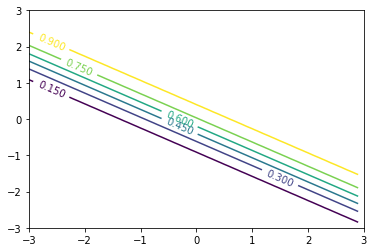

In [18]:
# Use this cell to experiment
plot_logistic_contour(beta0=1, betaX=2, betaY=3)

<div class="exercise"><b>Exercise 2</b></div>
1. What happens to the decision boundary as the coefficient on X increases?
2. What happens if you increase the Y coefficient to match?
3. What does the constant term control?
4. What impact do higher-order and interaction terms have on the boundary?
5. What parameter settings should I show the class?

**Answers**:

*your answer here* 


In [ ]:
# %load solutions/boundaries.txt

1. The boundary tips towards vertical
2. The boundary is in the same place as it was originally, but is squished together. The model is much more certain about how to predict points a given distance from the boundary
3. It shifts the boundary, perpendicular to its current orientation
4. Including squared terms allows quadratic decision boundaries, and the interraction term allows hyperbolic boundaries


## Part 3 (The Real Challenge): Multiclass Classification
Before we move on, let's consider a more common use case of logistic regression: predicting not just a binary variable, but what level a categorical variable will take. Instead of breaking the quality variable into 'good' and 'other', let's discretize into 'good, 'medium', and 'bad'.

In [36]:
# copy the original data so that we're free to make changes
wines_df_recode = wines_df.copy()

# use the 'cut' function to reduce a variable down to particular bins. Here the lowest bin is 0-4, next is 5-7,
# and the last is 7-10
wines_df_recode['quality'] = pd.cut(wines_df_recode['quality'],[0,4,7,10], labels=[0,1,2])

# drop the un-needed columns
x_data = wines_df_recode.drop(['quality','good'], axis=1)
y_data = wines_df_recode['quality']

x_train,x_test, y_train,y_test = train_test_split(x_data, y_data, test_size=.2, random_state=8, stratify=y_data)

print(wines_df['quality'].head())
print(wines_df_recode['quality'].head())

The `cut` function obviously stores a lot of extra information for us. It's a very useful tool for discretizing an existing variable.

<div class="exercise"><b>Exercise 3</b></div>
1. Adapt your earlier logistic regression code to fit to the new training data. What is stored in `.coef_` and `.intercept_`?
2. How well does this model predict the test data?
3. Put the model's performance in context. Think of a trivial model to compare to, and provide its accuracy score on the test set.

**Answers**:

1.

In [17]:
# your code here 


In [ ]:
# %load solutions/multi_logistic.py
from sklearn.linear_model import LogisticRegression

fitted_lr = LogisticRegression(C=1000000, solver='newton-cg', max_iter=250).fit(x_train,y_train)
print("Coefficients:")
print(fitted_lr.coef_)
print("Intercepts:")
print(fitted_lr.intercept_)


*your answer here*


In [ ]:
# %load solutions/multi_logistic.txt
1\. We get three sets of coefficients, and three intercepts. 

We need three sets because (under the default 'one versus rest' strategy) we fit three models. When predicting, model 1 reports a probability of the new example coming from class A or from the cloud of remaining classes. Model 2 reports the probability of whether the example comes from class B or the cloud of remaining classes, and so on. We take this set of scores and pick the biggest one (we classify as whichever class has the biggest ratio of "this class" to "not this class").

2. 

In [20]:
# your code here 


In [ ]:
# %load solutions/score1.py
fitted_lr.score(x_test,y_test)

*your answer here* 


3.

In [22]:
# make a dumb prediction that always guesses 1, the most common class
# your code here 


In [ ]:
# %load solutions/trivial_model.py
dumb_prediction = np.ones(len(y_test))
np.sum(y_test == dumb_prediction) / len(y_test)

*your solution here*

But, a trivial model that guesses the most likely class also does really well on the test set, too.

In [ ]:
# %load solutions/3.3.txt
print('But, a trivial model that guesses the most likely class also does really well on the test set, too.')

#### Summary
- Logistic regression extends OLS to work naturally with a dependent variable that's only ever 0 and 1.
- In fact, Logistic regression is even more general and is used for predicting the probability of an example belonging to each of $N$ classes.
- The code for the two cases is identical and just like `LinearRegression`: `.fit`, `.score`, and all the rest
- Significant predictors does not imply that the model actually works well. Signifigance can be driven by data size alone.
- The data aren't enough to do what we want

**Warning**: Logistic regression _tries_ to hand back valid probabilities. As with all models, you can't trust the results until you validate them- if you're going to use raw probabilities instead of just predicted class, take the time to verify that if you pool all cases where the model says "I'm 30% confident it's class A" 30% of them actually are class A.

## Part 4: Dimensionality Reduction
Our models are clearly struggling, but it's hard to tell why. Let's PCA to shrink the problem down to 2d (with as little loss as possible) and see if that gives us a clue about what makes this problem tough.

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# scale the datasets
scale_transformer = StandardScaler(copy=True).fit(x_train)
x_train_scaled = scale_transformer.transform(x_train)
x_test_scaled = scale_transformer.transform(x_test)


# reduce dimensions
pca_transformer = PCA(2).fit(x_train_scaled)
x_train_2d = pca_transformer.transform(x_train_scaled)
x_test_2d =  pca_transformer.transform(x_test_scaled)

print(x_train_2d.shape)
x_train_2d[0:5,:]

Some comments:
1. Both scaling and reducing dimension follow the same pattern: we fit the object to the training data, then use .transform to convert the training and test data. This ensures that, for instance, we scale the test data using the _training_ mean and variance, not its own mean and variance
2. We need to equalize the variance of each feature before applying PCA, otherwise certain dimensions will dominate the scaling: our PCA dimensions would just be the features with the largest spread.

In [26]:
## plot each group

# notice that we set up lists to track each group's plotting color and label
colors = ['r','c','b']
label_text = ["Bad Wines", "Medium Wines", "Good Wines"]

# and we loop over the different groups
for cur_quality in [0,1,2]:
    cur_df = x_train_2d[y_train==cur_quality]
    plt.scatter(cur_df[:,0], cur_df[:,1], c = colors[cur_quality], label=label_text[cur_quality])
    
# all plots need labels
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimention 2")
plt.legend();

Well, that gives us some idea of why the problem is difficult: the good wines and bad wines are hiding right among the average wines. It does look like the wines separate into two groups, though, possibly one for reds and one for whites.

<div class="exercise"><b>Exercise 4</b></div>
1. What critique can you make against the plot above? Why does this plot not prove that the different wines are hopelessly similar?
2. The wine data we've used so far consist entirely of continuous predictors. Would PCA work with categorical data?

**Answer**:

*your answer here* 


In [ ]:
# %load solutions/4.txt
print('1. The PCA dimensions are chosen without regard to the y variable. Thus it is possible that the very next PCA dimension will lift the red points up out of the page, push the blue points down into it, and leave the cyan points where they are; such a dimension would separate the different types of wine and make classification easy.')
print('2. PCA would not work with categorical data. PCA requires there to be a meaningful notion of distance between points. Categorical or ordinal data is not enough.')

<div class="exercise"><b>Exercise 5</b></div>
1. Edit the code above to plot the locations of red wines and white wines


**Answer**:

In [28]:
# your code here 


## Evaluating PCA -  Variance Explained
One of the criticisms we made of the PCA plot was that it's lost something from the original data.

Let's actually investigate how much of the original data's structure the 2d PCA captures. We'll look at the `explained_variance_ratio_` portion of the PCA fit. This lists, in order, the percentage of the x data's total variance that is captured by the nth PCA dimension.

In [29]:
var_explained = pca_transformer.explained_variance_ratio_
print("Variance explained by each PCA component:", var_explained)
print("Total Variance Explained:", np.sum(var_explained))

The first PCA dimension captures 33% of the variance in the data, and the second PCA dimension adds another 20%. Together, we've got about half of the total variation in the training data covered with just these two dimensions.

<div class="exercise"><b>Exercise 6</b></div>
1. Fit a PCA that finds the first 10 PCA components of our training data
2. Use `np.cumsum` to print out the variance we'd be able to explain by using n PCA dimensions for n=1 through 10
3. Does the 10-dimension PCA agree with the 2d PCA on how much variance the first components explain? Do the 10d and 2d PCAs find the same first two dimensions? Why or why not?
4. Make a plot of number of PCA dimensions against total variance explained. What PCA dimension looks good to you?

Hint: `np.cumsum` stands for 'cumulative sum', so `np.cumsum([1,3,2,-1,2])` is `[1,4,6,5,7]`

**Answer**:

In [30]:
#your code here 


3\. 

*your answer here* 


In [ ]:
# %load solutions/6.3.txt
print('The 10d PCA and the 2d PCA agree about how much variance the first two components explain. The 10d and 2d PCA give the same components in the same order. This means it is safe to simply fit a PCA with the largest number of components you expect you will need, and take a subset as appropriate.')

4.

In [32]:
#your code here 


In [ ]:
# %load solutions/6.4.py
plt.scatter(range(1,11),np.cumsum(pca_10_transformer.explained_variance_ratio_))
plt.xlabel("PCA Dimension")
plt.ylabel("Total Variance Captured")
plt.title("Variance Explained by PCA");

A PCA dimension of 3, 4, or 5 looks good to me. These values are roughly where we hit diminishing returns on variance explained.

Plots like the one above are called 'Scree' or 'Elbow' plots. They are often used to heuristically select a good number of PCA dimensions.

#### Summary
- PCA maps a high-dimensional space into a lower dimensional space.
- The PCA dimensions are ordered by how much of the original data's variance they capture
    - There are other cool and useful properties of the PCA dimensions (orthogonal, etc.). See a [textbook](http://math.mit.edu/~gs/linearalgebra/).
- PCA on a given dataset always gives the same dimensions in the same order.
- You can select the number of dimensions by fitting a big PCA and examining a plot of the cumulative variance explained.

## Part 5: Did we fail?
None of the models worked, and we can't tell good wines from bad. Was it all a waste of time and money?

Not really. All analyses are a roll of the dice. Some analyses fail, like this one did, becuase the data at hand just don't support the task we've set out.

What can we do about it?
1. Be honest about the methods and the null result. Lots of analyses fail.
2. Collect a dataset you think has a better chance of success. Maybe we collected the wrong chemical signals...
3. Keep trying new approaches. Just beware of overfitting the data you're validating on. Always have a test set locked away for when the final model is built.
4. Change the question. Maybe something you noticed during analysis seems interesting or useful (classifying red versus white). But again, you the more you try, the more you might overfit, so have test data locked away.
5. Just move on. If the odds of success start to seem small, maybe you need a new project.

#### The Moral of the Lab
- Sometimes, the data just aren't enough to adequately predict outcomes.
- In this lab we saw that no amount of modeling finesse would let us use a wine's chemical properties to tell good wines and bad wines from mediocre ones.
    - The chemical properties were very good at telling red wines from whites, however.
- PCA helped us visualize the data and confirm that the highly rated wines just aren't chemically distinct from the other wines.
- **NOT ALL ANALYSES YIELD USEFUL RESULTS** Sometimes (arguably most of the time), the data aren't suitable for a task or just don't have anything interesting to say.

## Part 6 (Sidebar): Weighting the training points
Some models can accept weights on the training points to given them greater priority in the model's fitting process. This can be useful if, for instance, certain classes are rare but we want to be sure the model classifies them correctly (e.g. we're trying to classify cancers and one form is rare but very aggressive). In general, weighting training points is like moving along the ROC curve; we change some model parameters to alter the mistakes the model makes to be more in line with our tastes.

Let's see this in action with a logistic regression:

In [39]:
# copy the original data so that we're free to make changes
wines_df_recode = wines_df.copy()

# use the 'cut' function to reduce a variable down to particular bins. Here the lowest bin is 0-4, next is 5-7,
# and the last is 7-10
wines_df_recode['quality'] = pd.cut(wines_df_recode['quality'],[0,4,7,10], labels=[0,1,2])

# drop the un-needed columns
x_data = wines_df_recode.drop(['quality','good'], axis=1)
y_data = wines_df_recode['quality']

x_train,x_test, y_train,y_test = train_test_split(x_data, y_data, test_size=.2, random_state=8, stratify=y_data)

print(wines_df['quality'].head())
print(wines_df_recode['quality'].head())

In [49]:
unweighted_lr = LogisticRegression(C=1000000).fit(x_train,y_train)

weight_dict = {0:1000, 1:1 , 2:100}
weighted_lr = LogisticRegression(C=1000000, class_weight=weight_dict).fit(x_train,y_train)

In [50]:
from sklearn.metrics import confusion_matrix

print("Rows: True Lables (Bad, Medium, Good), \nColummns: Predicted Lables (Bad, Medium, Good)")
print()
print("unweighted:")
print(confusion_matrix(y_test, unweighted_lr.predict(x_test)))
print("weighted:")
print(confusion_matrix(y_test, weighted_lr.predict(x_test)))

Without weighting, the model plays it safe and predicts that all of the test set wines are medium. With weighting, the model is told to care more about getting the bad and good wines right. The model does as we've asked and correctly IDs 3 good/bad test wines, at the price of 17 falsely bad wines and 16 falsely good wines. However, if identifying bad and good wines is, as implied, 100 times more important than identifying medium wines, we've made a really good trade.


<div class="exercise"><b>Exercise 7</b></div>
1. What happens if you give a weight of 0 to the medium wines?
2. What weighting gives results that accord with your personal sense of what the model should be doing? How many actually-medium bottles is a single good bottle worth?

**Answers**:
1. The model learns a classification rule that never predicts 'medium'. It's as it we dropped the medium wines from training.
2. 100, 1, 100 looks the best to me. We get a 1-in-8 sucess rate on the wines flagged as good. However, I found these values by looking at the test set confusion matrix; it's not clear they'd maintain the 1-in-8 ratio on new data.